<center> <H1>EE 610: Assignment 2 </H1></center>
<center> <H2>Name: Vinit Awale</H2></center>
<center> <H2>Roll No. 18D070067</H2></center>

## IMPORTS

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch

## Hyperparameters

In [2]:
size = 321

## Question 2
### Part a)

We select the largest window size W = 13

In [3]:
W = 23


### Part b)

We use the following blur kernels of size W = 13
- simple blur kernel
- gaussian blur kernel
- median blur kernel

In [4]:
blurs = [cv2.blur , cv2.GaussianBlur]

In [5]:
kernel_sizes = [1,3,5,7,9]

The noise models that we use are the following:
- Gaussian noise with mean 0 
- Salt and pepper noise with probability 0.05

In [6]:
Gaussian_noise = np.random.normal(0, 0.1, (size,size,3))*20
Salt_and_pepper_noise = np.random.randint(-1, 2, (size,size,3))*10

In [7]:
noises = [Gaussian_noise, Salt_and_pepper_noise]

In [8]:
# Load training images and resize them to 321x321
def load_images(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (321, 321))
        if img is not None:
            images.append(img)
    return images

path = "BSDS300\\images\\train"
images = load_images(path)
images = np.array(images)

### Part c)

In [9]:
degraded_images = []

for i in range(len(images)):
    img = np.float32(images[i])
    for _ in range(5):
        # Randomly select a blur function index
        blur_index = np.random.randint(0, len(blurs))
        random_blur_kernel = np.random.choice(kernel_sizes)

        if blur_index == 0:
            img = blurs[0](img, (random_blur_kernel, random_blur_kernel))
        elif blur_index == 1:
            img = blurs[1](img, ksize = (random_blur_kernel, random_blur_kernel), sigmaX = W)

        # Randomly select a noise function index from 0 or 1
        noise_func = noises[np.random.randint(0, 2)]
        
        # Add noise to the blurred image
        img = img + noise_func
    
    
    img = np.clip(img, 0, 255).astype(np.uint8)   # Clip and convert to uint8
    
    # Add the blurred and noisy image to the list of degraded images
    degraded_images.append(img)


### Visulaization of the degraded images

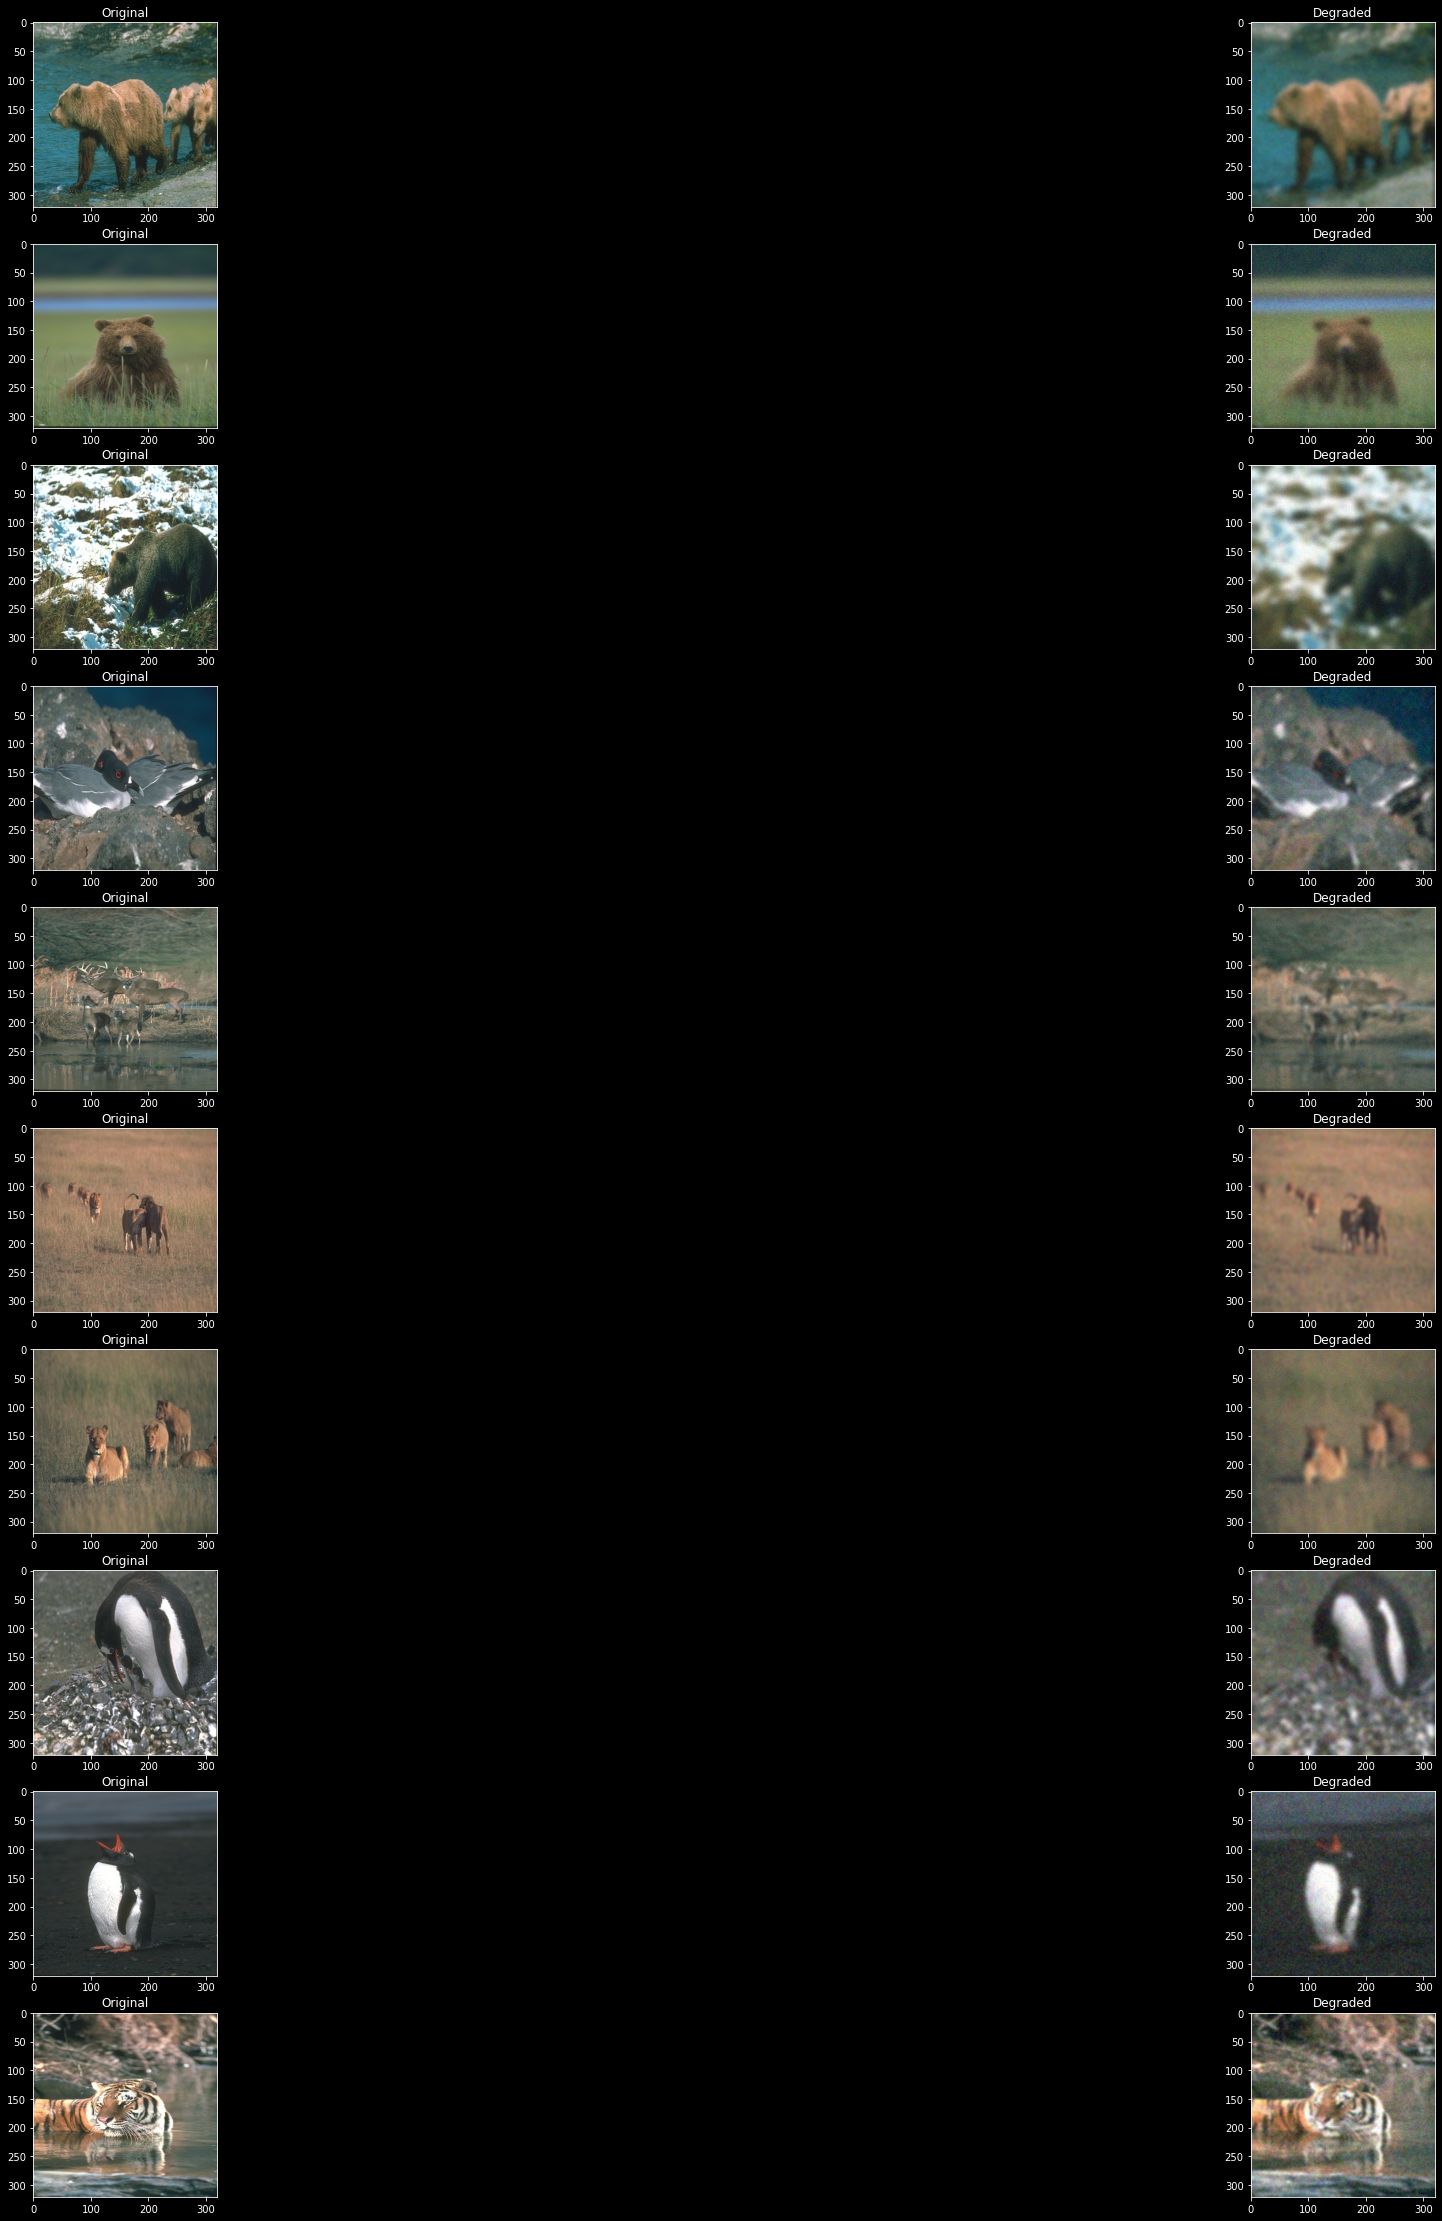

In [10]:
# Display the first 10 degraded images along with their original images
plt.figure(figsize=(40,40))
for i in range(10):
    plt.subplot(10,2,2*i+1)
    plt.imshow(images[i])
    plt.title('Original')
    plt.subplot(10,2,2*i+2)
    plt.imshow(degraded_images[i])
    plt.title('Degraded')
    

### Zoomed in on the following images to see the degradation.

Text(0.5, 1.0, 'Original')

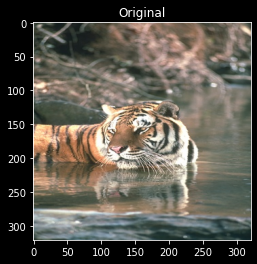

In [11]:
plt.imshow(images[9])
plt.title('Original')


Text(0.5, 1.0, 'Degraded')

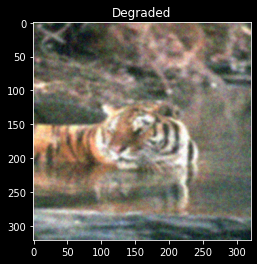

In [12]:
plt.imshow(degraded_images[9])
plt.title('Degraded')

### Hence, we can see that there is a clear degradation in the images.

### Extracting patches from the degraded images of size W = 13

In [13]:
## Extracting k random patches from the degraded images of size (W,W) and getting the central pixel of the patch from the original image for an image index

def get_random_patches(img_index, W, k):
    """ Function to get k random patches from the degraded images of size (W,W) and getting the central pixel of the patch from the original image for an image index

    Args:
        img_index (int): Index of the image from which the patches are to be extracted
        W (int): Width of the patch
        k (int): Number of patches to be extracted

    Returns:
        ndarray: Array of shape (k, W, W, 3) containing the k patches
    """
    patches = []
    central_pixels = []

    for i in range(0, img.shape[0] - W, W):
        for j in range(0, img.shape[1] - W, W):
            patch = degraded_images[img_index][i:i+W, j:j+W, :]
            patches.append(patch)
            central_pixels.append(images[img_index][i+W//2, j+W//2, :])


    # k random number from 1 to patches.shape[0]
    random_indices = np.random.randint(0, len(patches), k)

    # Randomly select k patches from the list of patches
    random_patches = [patches[i] for i in random_indices]
    random_central_pixels = [central_pixels[i] for i in random_indices]
    
    random_patches = np.array(random_patches)
    random_central_pixels = np.array(random_central_pixels)
    random_central_pixels = random_central_pixels.reshape(k,1,1,3)

    return random_patches, random_central_pixels

### Visualizing one of the patches and the corresponding center of the patch

In [14]:
patch, pixel =  get_random_patches(0, W, 10)

Text(0.5, 1.0, 'Random Patch')

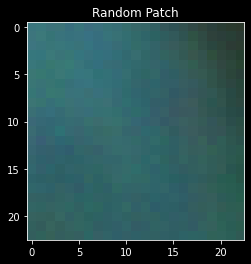

In [15]:
plt.imshow(patch[9])
plt.title('Random Patch')

Text(0.5, 1.0, 'Central Pixel of original image')

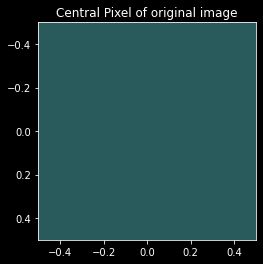

In [16]:
plt.imshow(pixel[9])
plt.title('Central Pixel of original image')

### Making patches of size W = 13 from the degraded images and the corresponding center of the patch

In [17]:
k = 50

In [18]:
patches = []
central_pixels = []

for i in range(len(degraded_images)):
    patch, pixel = get_random_patches(i, W, k)
    patches.append(patch)
    central_pixels.append(pixel)

patches = np.array(patches)
central_pixels = np.array(central_pixels)

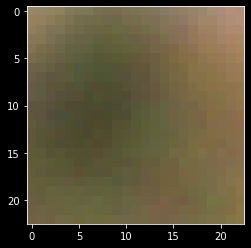

In [19]:
plt.imshow(patches[0][0])

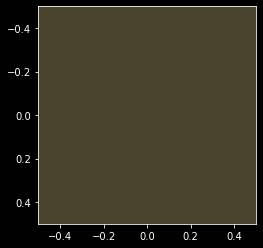

In [20]:
plt.imshow(central_pixels[0][0])

In [21]:
patches.shape

(200, 50, 23, 23, 3)

## Question 3

### Part a) We select w = 11

In [22]:
w = 11

### Part b) We use random forest regression to train the model

### Part c) 

In [23]:
## Function to read wxw patches from the degraded images and get the central pixel of the patch from the original image for an image index

def get_small_patches(patch,W, w):
    return patch[(W-w)//2:(W-w)//2+w, (W-w)//2:(W-w)//2+w, :]


### Visualizing a small patch of the degraded image

In [24]:
small_patch =  get_small_patches(patches[0][0], W, w)

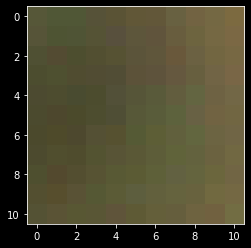

In [25]:
plt.imshow(small_patch)

In [26]:
## Get small_patches for all the patches

small_patches = []

for i in range(len(patches)):
    small_patch = []
    for j in range(len(patches[i])):
        small_patch.append(get_small_patches(patches[i][j], W, w))
    small_patches.append(small_patch)

small_patches = np.array(small_patches)
    

In [27]:
small_patches.shape

(200, 50, 11, 11, 3)

In [28]:
# Reshaping the small_patches and central_pixels 
small_patches = small_patches.reshape(200*k, w, w, 3)
central_pixels = central_pixels.reshape(200*k, 1, 1, 3)

In [29]:
# Shapes of the small_patches and central_pixels
print(small_patches.shape, central_pixels.shape)

(10000, 11, 11, 3) (10000, 1, 1, 3)


### Normalizing the small_patches channel-wise

In [30]:
normalized_small_patches = []

for i in range(200*k):
    patch = small_patches[i]
    R = patch[:,:,0]
    G = patch[:,:,1]
    B = patch[:,:,2]

    # Calculate the mean of the R, G, B channels
    R_mean = np.mean(R)
    G_mean = np.mean(G)
    B_mean = np.mean(B)

    # Calculate the standard deviation of the R, G, B channels
    R_std = np.std(R)
    G_std = np.std(G)
    B_std = np.std(B)

    # Normalize the R, G, B channels
    R_norm = (R - R_mean) / R_std
    G_norm = (G - G_mean) / G_std
    B_norm = (B - B_mean) / B_std

    # Concatenate the normalized R, G, B channels
    norm_patch = np.concatenate((R_norm[:,:,np.newaxis], G_norm[:,:,np.newaxis], B_norm[:,:,np.newaxis]), axis=2)

    normalized_small_patches.append(norm_patch)

normalized_small_patches = np.array(normalized_small_patches)

### Normalizing the center_patch 

In [31]:
central_pixels_norm = central_pixels

In [32]:
## Flatten the normalized_small_patches and central_pixels_norm before passing them through the network

normalized_small_patches = normalized_small_patches.reshape(200*k, w*w*3)
central_pixels_norm = central_pixels_norm.reshape(200*k, 3)

In [307]:
## Now we train a random forest regression model to predict the central pixel of the patch from the small_patches

from sklearn.ensemble import RandomForestRegressor

Regressor = RandomForestRegressor(n_estimators=100, random_state=0)

Regressor.fit(normalized_small_patches, central_pixels_norm)

# The MSE of the model
print(Regressor.score(normalized_small_patches, central_pixels_norm))

0.9143956622275035


In [308]:
temp = Regressor.predict(normalized_small_patches[0:1])

In [309]:
temp.shape

(1, 3)

In [310]:
# temp = temp*255
temp = temp.reshape(1,1,3)
temp = temp.astype(np.uint8)

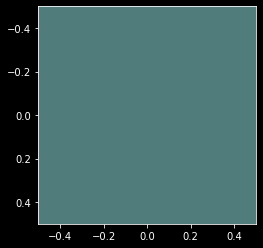

In [311]:
plt.imshow(temp)

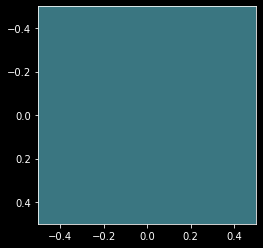

In [312]:
plt.imshow(central_pixels[0])

In [316]:
# Reconstruct the image from the small_patches and the predicted central pixel

img = degraded_images[1].astype(np.float32)

reconstruct_image = np.zeros((img.shape[0]-w, img.shape[1]-w, 3))
for x in range(0, img.shape[0] - w):
    vertical_patch = []
    for y in range(0, img.shape[1] - w):
        print("x = ", str(x), "y = ", str(y))
        patch = img[x:x+w, y:y+w, :]
        # Normalize the patch
        R = patch[:,:,0]
        G = patch[:,:,1]
        B = patch[:,:,2]

        # Calculate the mean of the R, G, B channels
        R_mean = np.mean(R)
        G_mean = np.mean(G)
        B_mean = np.mean(B)

        # Calculate the standard deviation of the R, G, B channels
        R_std = np.std(R)
        G_std = np.std(G)
        B_std = np.std(B)

        # Normalize the R, G, B channels
        R_norm = (R - R_mean) / R_std
        G_norm = (G - G_mean) / G_std
        B_norm = (B - B_mean) / B_std

        # Concatenate the normalized R, G, B channels
        norm_patch = np.concatenate((R_norm[:,:,np.newaxis], G_norm[:,:,np.newaxis], B_norm[:,:,np.newaxis]), axis=2)

        # Concatanate the normalized patch to the vertical_patch
        vertical_patch.append(norm_patch)

    vertical_patch = np.array(vertical_patch)
    # Predict the central pixel of the patch
    central_pixel = Regressor.predict(vertical_patch.reshape(-1, w*w*3))

    # Concatanate the vertical_patch to the reconstruct_image
    reconstruct_image[x,:,:] = central_pixel

# reconstruct_image = reconstruct_image*255
reconstruct_image = np.clip(reconstruct_image, 0, 255).astype(np.uint8)


x =  0 y =  0
x =  0 y =  1
x =  0 y =  2
x =  0 y =  3
x =  0 y =  4
x =  0 y =  5
x =  0 y =  6
x =  0 y =  7
x =  0 y =  8
x =  0 y =  9
x =  0 y =  10
x =  0 y =  11
x =  0 y =  12
x =  0 y =  13
x =  0 y =  14
x =  0 y =  15
x =  0 y =  16
x =  0 y =  17
x =  0 y =  18
x =  0 y =  19
x =  0 y =  20
x =  0 y =  21
x =  0 y =  22
x =  0 y =  23
x =  0 y =  24
x =  0 y =  25
x =  0 y =  26
x =  0 y =  27
x =  0 y =  28
x =  0 y =  29
x =  0 y =  30
x =  0 y =  31
x =  0 y =  32
x =  0 y =  33
x =  0 y =  34
x =  0 y =  35
x =  0 y =  36
x =  0 y =  37
x =  0 y =  38
x =  0 y =  39
x =  0 y =  40
x =  0 y =  41
x =  0 y =  42
x =  0 y =  43
x =  0 y =  44
x =  0 y =  45
x =  0 y =  46
x =  0 y =  47
x =  0 y =  48
x =  0 y =  49
x =  0 y =  50
x =  0 y =  51
x =  0 y =  52
x =  0 y =  53
x =  0 y =  54
x =  0 y =  55
x =  0 y =  56
x =  0 y =  57
x =  0 y =  58
x =  0 y =  59
x =  0 y =  60
x =  0 y =  61
x =  0 y =  62
x =  0 y =  63
x =  0 y =  64
x =  0 y =  65
x =  0 y =  66
x =  

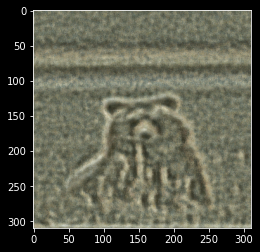

In [317]:
plt.imshow(reconstruct_image)

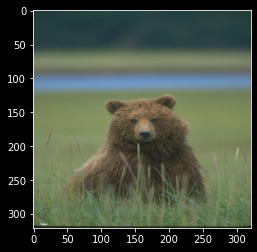

In [318]:
plt.imshow(images[1])

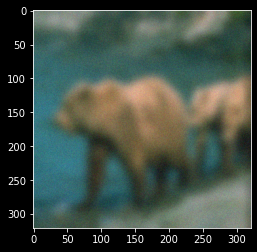

In [ ]:
plt.imshow(degraded_images[0])

In [315]:
reconstruct_image

array([[[119, 120, 100],
        [103, 114, 103],
        [126, 134, 115],
        ...,
        [123, 123, 105],
        [106, 113,  92],
        [116, 116,  98]],

       [[104, 107,  89],
        [ 97, 104,  88],
        [131, 131, 111],
        ...,
        [104, 107,  85],
        [111, 111,  94],
        [121, 121, 100]],

       [[111, 115,  98],
        [ 99, 107,  91],
        [122, 124, 108],
        ...,
        [140, 132, 105],
        [134, 130, 101],
        [111, 111,  86]],

       ...,

       [[108, 110,  90],
        [107, 108,  85],
        [102, 105,  86],
        ...,
        [174, 170, 136],
        [170, 164, 134],
        [168, 166, 140]],

       [[100, 108,  94],
        [ 99, 102,  86],
        [112, 114,  94],
        ...,
        [167, 162, 135],
        [171, 166, 133],
        [163, 160, 131]],

       [[ 95, 103,  91],
        [ 97, 101,  84],
        [ 96,  97,  77],
        ...,
        [176, 163, 136],
        [191, 181, 155],
        [170, 169, 143]]

In [304]:
images[0]

array([[[102, 119, 100],
        [108, 122, 102],
        [115, 126, 107],
        ...,
        [ 21,  33,  23],
        [ 27,  31,  27],
        [ 28,  30,  28]],

       [[ 98, 115,  97],
        [102, 116,  98],
        [114, 124, 107],
        ...,
        [ 22,  34,  24],
        [ 27,  31,  28],
        [ 28,  30,  29]],

       [[107, 125, 109],
        [109, 122, 108],
        [120, 130, 114],
        ...,
        [ 26,  37,  26],
        [ 27,  29,  26],
        [ 29,  31,  30]],

       ...,

       [[ 41,  69,  55],
        [ 43,  71,  57],
        [ 49,  77,  63],
        ...,
        [ 53,  54,  46],
        [ 43,  43,  34],
        [ 39,  39,  31]],

       [[ 45,  73,  61],
        [ 49,  77,  63],
        [ 52,  80,  66],
        ...,
        [ 44,  48,  39],
        [ 44,  44,  36],
        [ 36,  38,  31]],

       [[ 49,  79,  69],
        [ 46,  75,  63],
        [ 59,  87,  75],
        ...,
        [ 44,  50,  41],
        [ 41,  42,  34],
        [ 34,  37,  29]]

In [39]:
## Make a neural network with 3 outputs

import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.linear1 = nn.Linear(w*w*3, 100)
        self.linear2 = nn.Linear(100, 100)
        self.linear3 = nn.Linear(100, 3)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x

num_epochs = 100
device = "cuda" if torch.cuda.is_available() else "cpu"

model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

for epoch in range(num_epochs):
    # Use normalised_small_patches and central_pixels_norm as inputs
    # Use the output of the network as the predicted central pixel of the small_patches

    normalized_small_patches_tensor = torch.from_numpy(normalized_small_patches.astype(np.float32))
    central_pixels_norm_tensor = torch.from_numpy(central_pixels_norm)

    normalized_small_patches_tensor = normalized_small_patches_tensor.to(device)
    central_pixels_norm_tensor = central_pixels_norm_tensor.to(device)


    # Forward pass: compute predicted y by passing x to the model
    y_pred = model(normalized_small_patches_tensor)
    loss = criterion(y_pred, central_pixels_norm_tensor)

    print("Epoch : ", epoch, "Loss : ", loss.item())

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()

    optimizer.step()


        

RuntimeError: Expected object of scalar type Long but got scalar type Byte for argument #2 'target' in call to _thnn_nll_loss_forward

In [338]:
normalized_small_patches.shape

(10000, 363)

In [332]:
w*w*3

363